# What you'll learn

After watching this video, you will be able to:
* Explain how to create Tekton events.
* Explain how to create Tekton triggers.
* Describe how to use events and triggers to start a Tekton pipeline.

# Conceptual building blocks

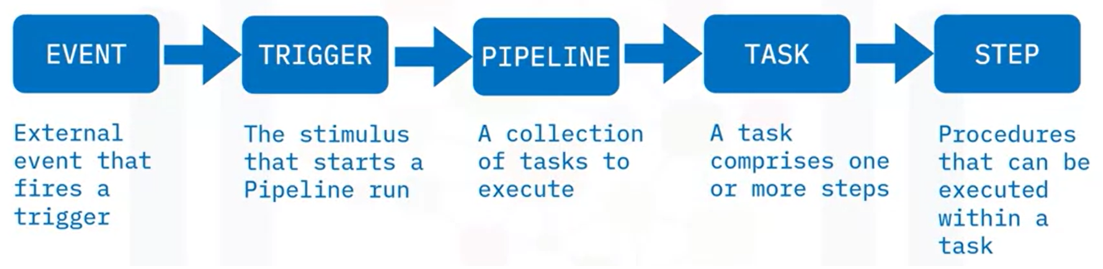

* If you refer back to the conceptual building blocks of `events`, `triggers`, `pipelines`, `tasks`, and `steps`.
* Let’s look closer at `events` and `triggers`.

# Tekton Triggers

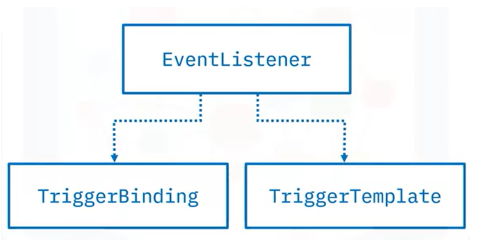

* **Tekton triggers** allow your pipeline to respond to external events.
* They do this with a **custom resource definition** (or CRD) known as an `EventListener` that points to two other CRDs.
* The `TriggerBinding` CRD, which takes data from the event and binds it to the properties in your pipeline.
* The `TriggerTemplate` CRD, which takes data from the binding and instantiates a `PipelineRun`, passing in that data.

# Tekton triggers flow

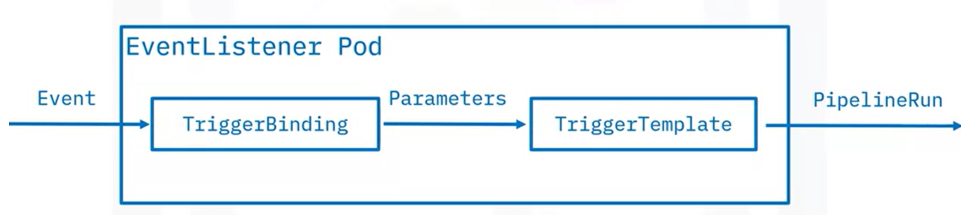

Let's take a look at **how these triggers flow**.
* When you create an `EventListener`, **it creates a pod running in Kubernetes** that listens for events.
* When some external event happens, it's sent to the `EventListener` pod:
    * which causes the `TriggerBinding` to be instantiated, and
    * **pull information from the event and bind it to the parameters** that the pipeline needs.
* The **parameters** from the `TriggerBinding` are then forwarded to the `TriggerTemplate`.
* The `TriggerTemplate` instantiates a `PipelineRun` which, as its name implies, runs your pipeline.
* This new `PipelineRun` resource starts, and your pipeline begins to run.

# EventListener

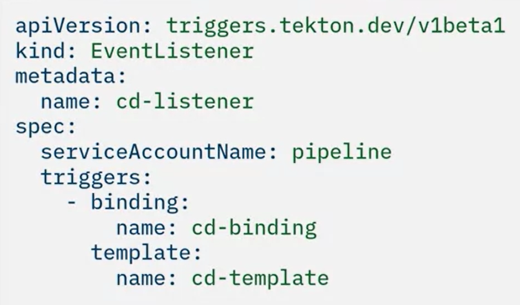

Let's build a simple `EventListener` for a CD pipeline.
* You start by specifying the `apiVersion`, which is `triggers.tekton.dev/v1beta1`.
* Then, you specify the `kind` of resource, which is an `EventListener`.
*  Using the `metadata`, you give it the `name` **"cd-listener"**.
* Now you can add the specifications (`spec`).
    * You specify the `serviceAccountName` of the **ServiceAccount** that the pipeline should run under.
    * In OpenShift, there is a preconfigured **ServiceAccount** named **"pipeline"** that is configured with the access control needed to run a pipeline, so you use that.
    * Now, you can specify the `triggers` for this `EventListener`.
        * You specify a binding with the `name` **"cd-binding"**, and a `template` with the `name` **"cd-template"**.

Whenever this `EventListener` receives an event, the data will first be passed to the binding `name` **"cd-binding"**, and then the binding will marshal that data into the parameters needed for the `trigger` `template` `name` **"cd-template"** and invoke that template.

# TriggerBinding

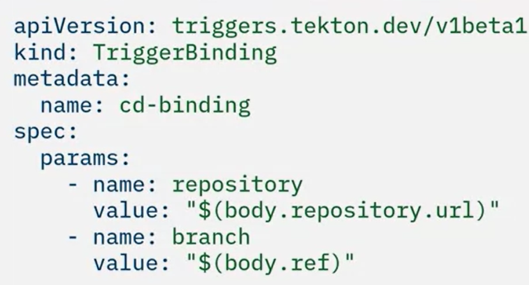

Now that you have the `EventListener`, you can create the **`TriggerBinding`** that it references.
* You start with the same `apiVersion` as before, and specify the resource `kind` as `TriggerBinding`.
* Using the `metadata`, you give it the `name` **"cd–binding"** so that it matches the `name` in the `EventListener`.
* Next, you define the **specifications** (`spec`), starting with the parameters.
    * The first parameter has the `name` **"repository"** with the value `body.repository.url`.
    * This is very specific to the **body** of the incoming event.
    * To figure this out for GitHub, you would look at the JSON file coming from the body of a GitHub event to understand where to pull these parameters from.
    * The second parameter has the `name` **"branch"** with a value that comes from `body.ref`.

This is how you bind the data from an incoming event to the parameters that your pipeline needs.

# TriggerTemplate

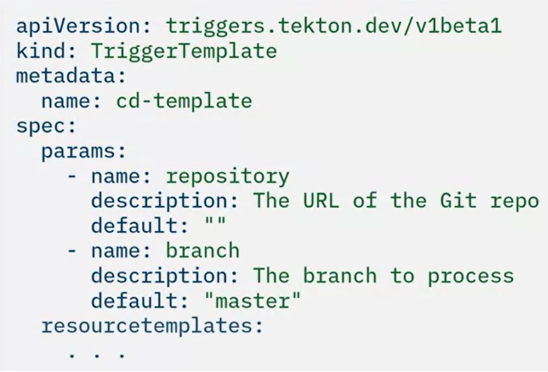

Now you need to specify the **trigger template** that was referenced in the **event listener**.
* Like the other resource definitions, it starts with the `apiVersion`.
* This time you specify the `kind` as `TriggerTemplate`.
* Using the` metadata`, you give it the `name` **"cd-template"** so that it matches the `name` in the `EventListener`.
* Next, you define the **specifications** (`spec`), starting with the parameters.
    * The first parameter `name` is **"repository"** and you give it a `description` and a `default` value that's empty.
    * The `description` is just used for documentation purposes, but the `default` value will be used if a **parameter** called **repository** is not passed in by the trigger binding.
    * The next parameter `name` **"branch"** also has a `description`, but this time the `default` value is **"master"**.
    * Again, if the `branch` parameter is not passed in from the **trigger binding**, the value of **"master"** will be used as the `branch` parameter for the pipeline.

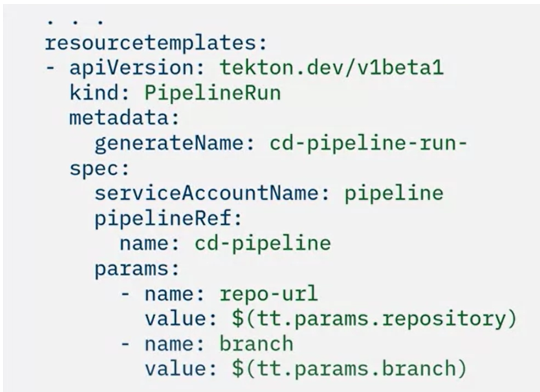

Now, you're ready to define the **`resourcetemplates`** to be used.
* This is all part of the same `TriggerTemplate` definition.
* The `resourcetemplates` section of the `TriggerTemplate` contains a `PipelineRun` resource.
* Like all the resources you have seen, it starts with an `apiVersion`.
* This is the regular Tekton API.
* The `kind` of resource is `PipelineRun`, which specifies the information needed to run a pipeline.
* In the `metadata` section, you could give it a `name`, or in this case, you could use **"generateName"** and specify a partial name.
    * This **generates a unique ID** and appends it to the partial name that you supply.
    * This is an effective way of giving all your pipeline runs a unique name.
* Next, you list the **specifications** (`spec`).
    * Again, you need to specify the `serviceAccountName` of the **ServiceAccount** that runs the pipeline.
    * You use the same **"pipeline"** account.
    * Now you specify the `pipelineRef`, which is a **reference to the pipeline** that you want to run.
    * The `name` you specify is **"cd-pipeline"**, assuming that you've defined a pipeline called **cd-pipeline** somewhere else.
* Next, you specify any **parameters** that this pipeline requires.
    * As you may have guessed, it needs a parameter for the repository, but you are using a different name here.
    * That's because you need to use the name that is specified by the pipeline you are calling.
    * The pipeline has defined this as **"repo-url"** so that's what you need to pass in.
    * You get the value from the `params` section of this `TriggerTemplate`, so you reference it as `$(tt.params.repository)`.
    * This shows you that the parameter names do not have to match as long as you can map them to each other.
    * The pipeline also needs a parameter `name` **"branch"** that also comes from the `params` section of this `TriggerTemplate`.
    * So, you reference it as `$(tt.params.branch)`.

Now you have everything you need to trigger a pipeline.

# Parameter flow

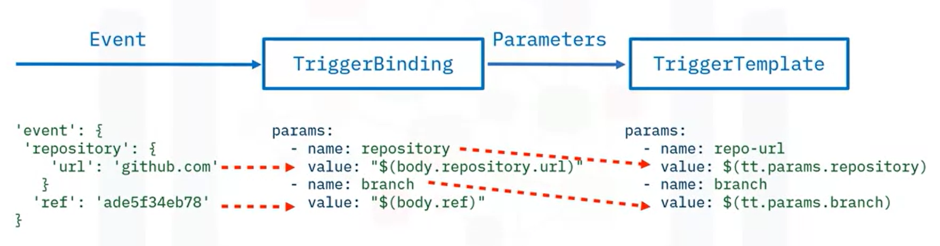

You saw that even if the parameter name doesn't always match, you were still able to map them to each other.

Let's take a look at how the parameters are flowing.
* You start with an event that has some data that you need for the pipeline.
* The trigger binding takes the data from the event and binds it to parameters.
* Those parameters are then mapped in the trigger template to the pipeline run so that they're available to the pipeline and all its tasks as parameter names that the pipeline expects to receive.
* You might be wondering, if you wrote these files yourself, **why wouldn’t you make all of the parameter names the same?**
* Normally, you would, but now you see that you can map existing pipelines with different parameter names and still make them work.

# Run the pipeline

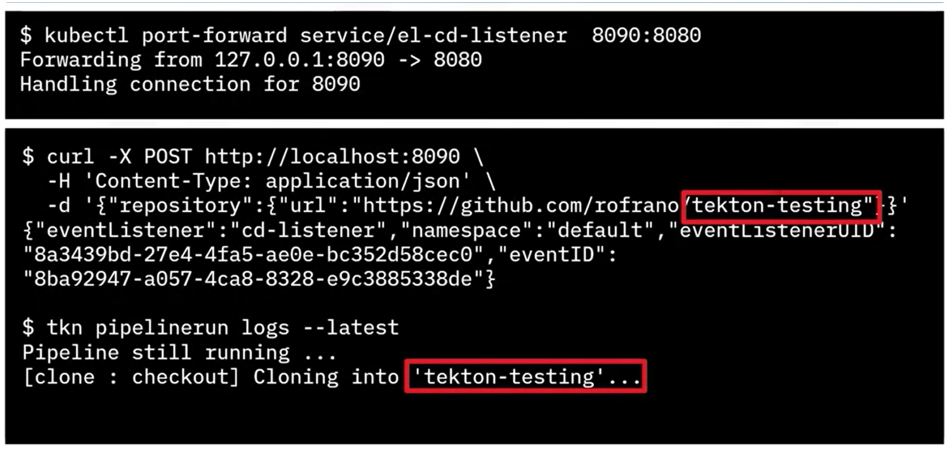

You are ready to see if your trigger works.

You can test this locally using the **curl** command.

Before you do, you need to locally expose the event listener.
* Normally, you would set up an **Ingress** to expose the `EventListener` as an **endpoint**.
* But for a quick check, you can use the Kubernetes `port-forward` command.
* This forwards the port the `EventListener` is listening on, which is port `8090`, to any port that you want, which in this case is `8080`.

Next, you use the **curl** command and `POST localhost:8090`.
* You set the `Content-Type` in the `header` to specify that the payload that you are sending is `application/json`.
* And finally, you use the `-d` parameter **to send the data in JSON format**.
* If you remember, you told the `TriggerBinding` to get the `repository` **parameter** from `body.repository.url`.
* So the body of your JSON message has a **"repository"** attribute with a **"url"** attribute under it.
* When you press ENTER, you receive a message from the `EventListener` letting you know that it has accepted your request.
* If you use the **`tekton pipelinerun logs --latest`** command to specify the latest logs, you see that the pipeline is still running, and eventually, you see the message from the **"checkout"** task that ran in the pipeline.
* Notice that the **name of the repository** in the message matches the name of the repository you told it to clone.

This is how you know that it worked.

# Summary

You learned that:
* Tekton `EventListeners` can be used to listen for external events.
* Tekton `TriggerBindings` can respond to those events and bind parameters from them.
* Tekton `TriggerTemplates` can create `PipelineRuns`, passing in the parameters to the pipeline.
* You can test your `EventListener` using the curl command.